# OOKLA BACKGROUND DATA ANALYSIS AND RESULTS

In [26]:
import dask.dataframe as dd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import  pandas as pd
import numpy as np

# Import 

In [4]:
raw_bg=dd.read_csv("android_bg_v2_2022-09-26.csv",
dtype={'locality': 'object','cell_bandwidths':'object','data_activity':'float64','data_state':'float64',
      'device_tac':'float64','display_state':'float64','downstream_bandwidth_kbps':'float64','postal_code':'float64','subregion':'object',
      'upstream_bandwidth_kbps':'float64','wifi_carrier_name':'object'})


# Filter Riyadh Mobily

In [5]:
raw_bg_ksa=raw_bg[raw_bg['network_operator_mcc_code']==420]
raw_bg_mobily=raw_bg_ksa[raw_bg_ksa['network_operator_mnc_code']==3]
raw_bg_mobily=raw_bg_mobily.query('locality in (\'Riyadh\')')
raw_bg_stc=raw_bg_ksa[raw_bg_ksa['network_operator_mnc_code']==1]
raw_bg_zain=raw_bg_ksa[raw_bg_ksa['network_operator_mnc_code']==4]
raw_bg_mobily_2g=raw_bg_mobily.query('connection_type in (3,4,18)')
raw_bg_mobily_3g=raw_bg_mobily.query('connection_type in (10,11,16)')
raw_bg_mobily_4g=raw_bg_mobily.query('connection_type in (15,21)')
raw_bg_mobily_5g=raw_bg_mobily.query('connection_type == 24')


In [6]:
# To get number of devices we need one row per device_id per tech
raw_bg_mobily_distinct=raw_bg_mobily.groupby(by=['device_id','device_model','device_manufacturer'])['report_id'].count().reset_index().compute()

In [7]:
def get_tech_from_conn_type(conn_type):
    ''' A helper function that converts conn_type to Tech'''
    if conn_type in (3,4,18):
        return "2G"
    if conn_type in (10,11,16):
        return "3G"
    if conn_type in (15,21):
        return "4G"
    if conn_type==24:
        return "5G"
    return "Other"

In [8]:
raw_bg_mobily_distinct_tech=raw_bg_mobily.groupby(by=['device_id','device_model','device_manufacturer','connection_type'])['report_id'].count().reset_index().compute()

In [9]:
raw_bg_mobily['tech']=raw_bg_mobily['connection_type'].apply(get_tech_from_conn_type)

In [10]:
# Get locations of samples showing 2g_3g
raw_bg_mobily.query('tech in (\'2G\',\'3G\')').compute().to_csv('2g_3g_locations.csv')

# Tech share By Number of Reports

<IPython.core.display.Javascript object>


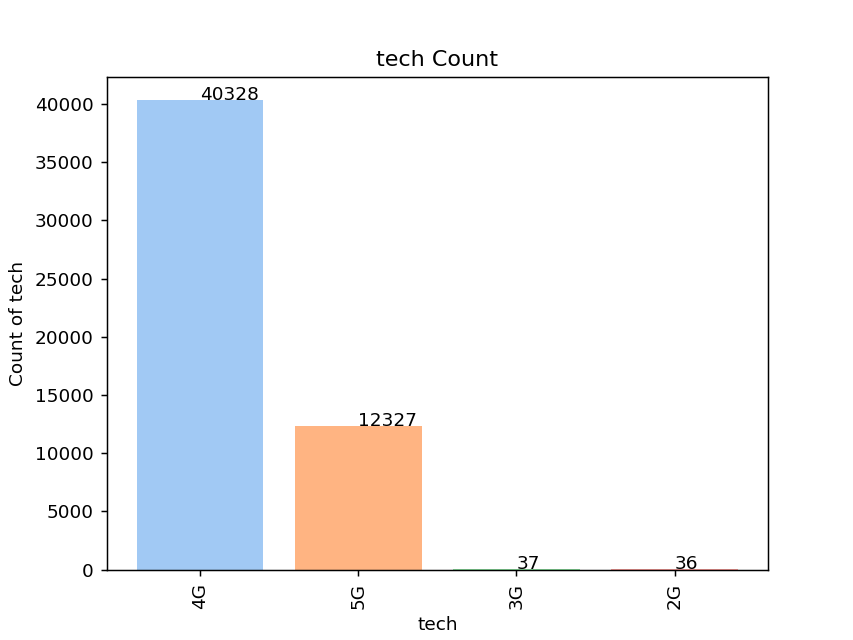

<IPython.core.display.Javascript object>


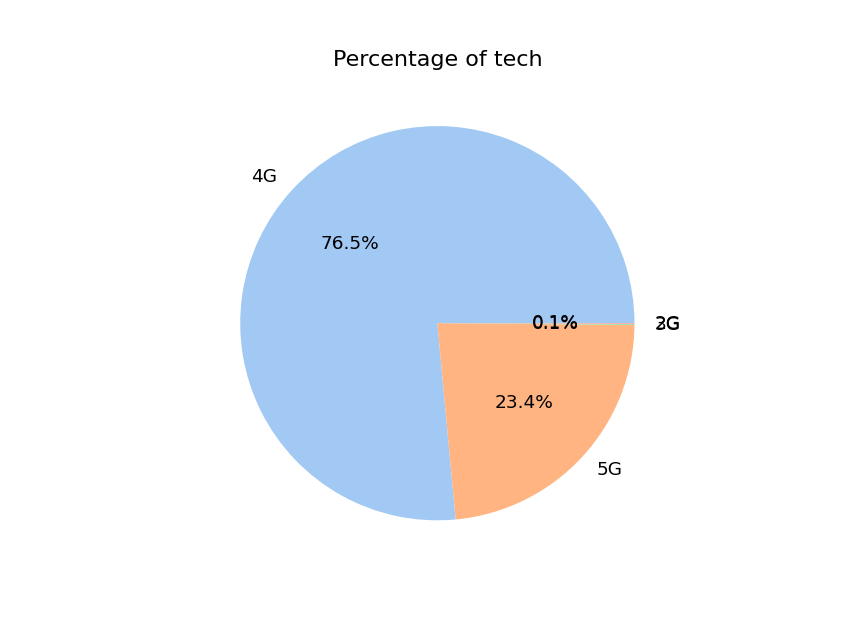

In [90]:
feature_analysis('tech',raw_bg_mobily[raw_bg_mobily['tech']!='Other'])

In [80]:
raw_bg_mobily['tech']=raw_bg_mobily['connection_type'].apply(get_tech_from_conn_type)

# Tech share By Number of Unique Devices

In [85]:
raw_bg_mobily_distinct_tech=raw_bg_mobily_distinct_tech[raw_bg_mobily_distinct_tech['tech']!='Other']

<IPython.core.display.Javascript object>


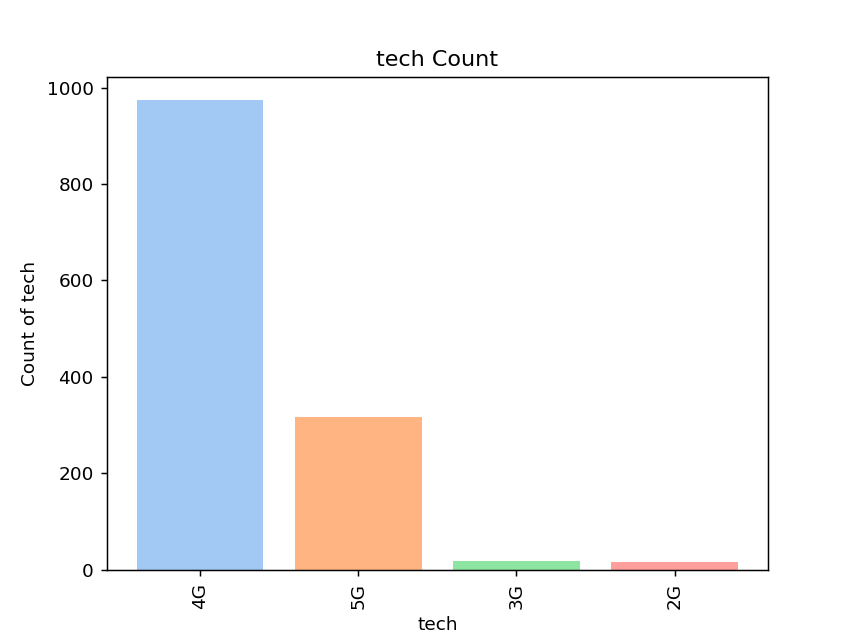

<IPython.core.display.Javascript object>


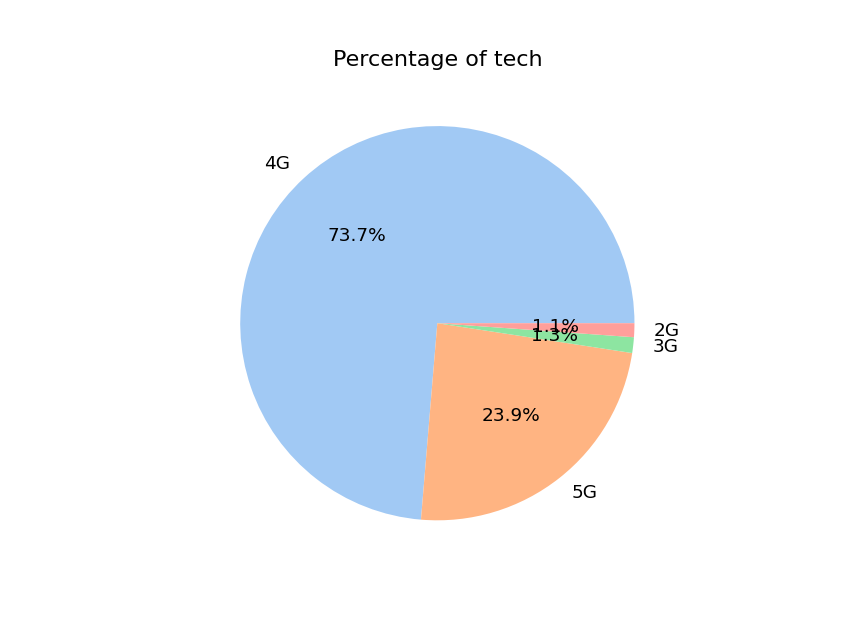

In [86]:
make_pie_chart_df('tech',raw_bg_mobily_distinct_tech)

In [53]:
raw_bg_mobily_distinct_2g['tech']="2G"
raw_bg_mobily_distinct_3g['tech']="3G"
raw_bg_mobily_distinct_4g['tech']="4G"
raw_bg_mobily_distinct_5g['tech']="5G"

<IPython.core.display.Javascript object>


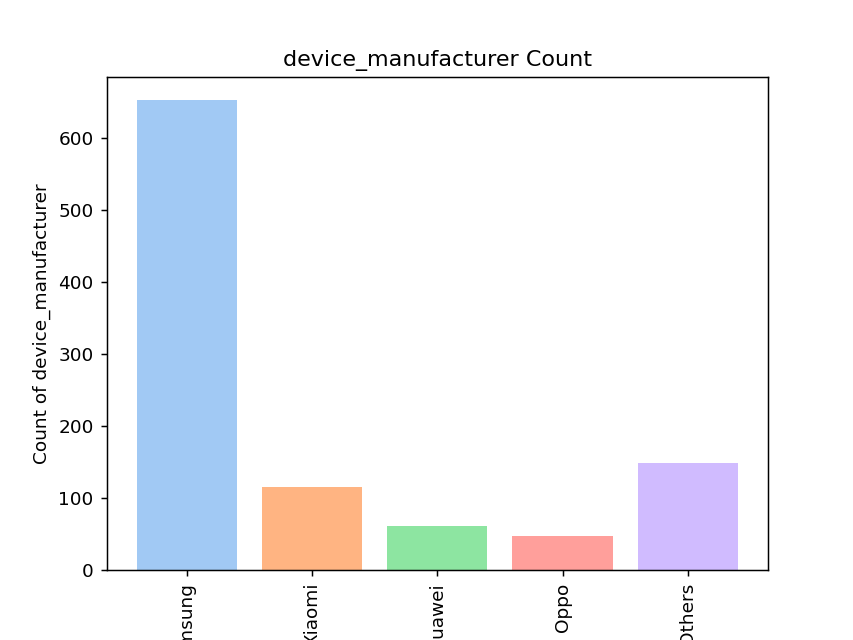

<IPython.core.display.Javascript object>


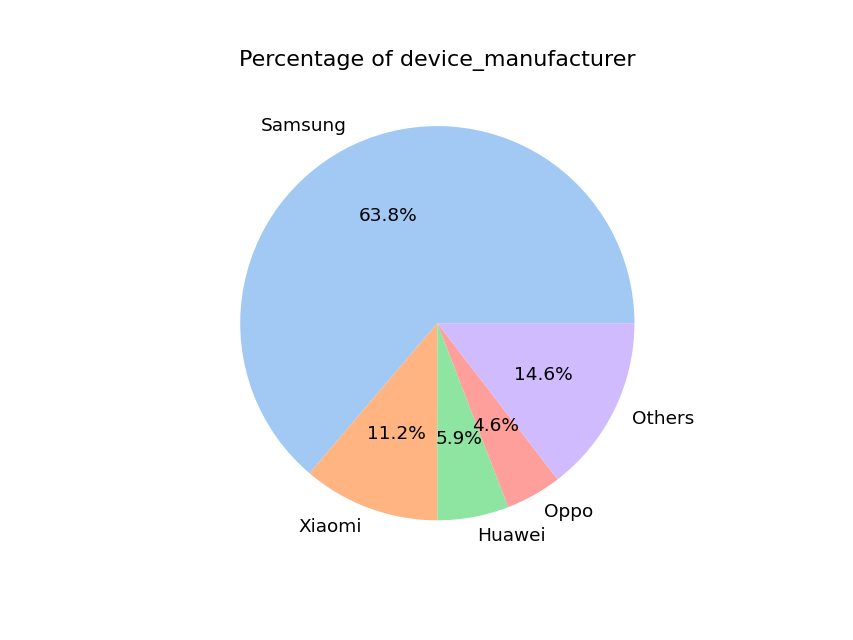

In [68]:
make_pie_chart_df('device_manufacturer',raw_bg_mobily_distinct_5g)

In [4]:
for col in raw_bg_mobily.columns:
    print(col)

report_id
trigger_name
result_date
received_date
received_date_local
time_zone_name
device_id
device_model
device_manufacturer
device_model_raw
device_manufacturer_raw
device_brand_raw
os_version
app_version
connection_type
is_airplane_mode
is_network_roaming
is_international_roaming
number_registered_networks
number_unregistered_networks
sim_operator_name
raw_sim_operator_name
sim_operator_mcc_code
sim_operator_mnc_code
network_operator_name
network_operator_mcc_code
network_operator_mnc_code
client_latitude
client_longitude
altitude
location_accuracy
location_age
location_type
country
region
subregion
locality
place_type
postal_code
computed_cellular_generation
tac
pci
cell_identifier
lte_enodeb
rnc_id
cell_id
arfcn
uarfcn
earfcn
is_primary_cell
rsrp
rsrq
rssi
rssnr
timing_advance
cqi
wifi_enabled
wifi_state
wifi_rssi
wifi_frequency
wifi_channel
app_foreground
azimuth
battery_level
battery_level_max
battery_plugged
battery_present
battery_status
battery_technology
battery_temperature

# Coverage

Measurements are dragged , so we need to take first measurement per cell

In [35]:
info_4g=raw_bg_mobily_4g[['device_id','result_date','client_latitude','client_longitude','lte_enodeb','cell_id','earfcn','rsrp','rsrq','cqi']].compute()

In [36]:
# Get first entry per ci 
# Note : We will loose info if a device travels near a cellid again
info_4g_first_per_ci=info_4g.groupby(by=['device_id','lte_enodeb','cell_id'],as_index=False)['result_date'].min()

In [37]:
# Filter total data based on above info
info_4g_corr_rsrp=info_4g_first_per_ci.merge(info_4g,left_on=['device_id','lte_enodeb','cell_id','result_date'],
                            right_on=['device_id','lte_enodeb','cell_id','result_date'])

In [38]:
# Store it for qgis analysis
info_4g_corr_rsrp.to_csv('First_entry_per_cell_v2.csv')

In [49]:
info_4g.groupby(by='device_id').count().sort_values(by='lte_enodeb',ascending=False)

,result_date,client_latitude,client_longitude,lte_enodeb,cell_id,earfcn,rsrp,rsrq,cqi
device_id,,,,,,,,,
410030546,1776,1776,1776,1765,1774,1765,1765,1765,0
371432627,1490,1490,1490,1490,1490,1490,1490,1490,0
410476724,1077,1077,1077,1077,1077,1077,1071,1077,906
252739436,1018,1018,1018,1018,1018,1018,1018,1018,0
378040434,886,886,886,886,886,886,886,886,852
...,...,...,...,...,...,...,...,...,...
399656760,4,4,4,0,4,0,0,0,0
347834388,1,1,1,0,1,0,0,0,0
412615864,1,1,1,0,1,0,0,0,0


<IPython.core.display.Javascript object>


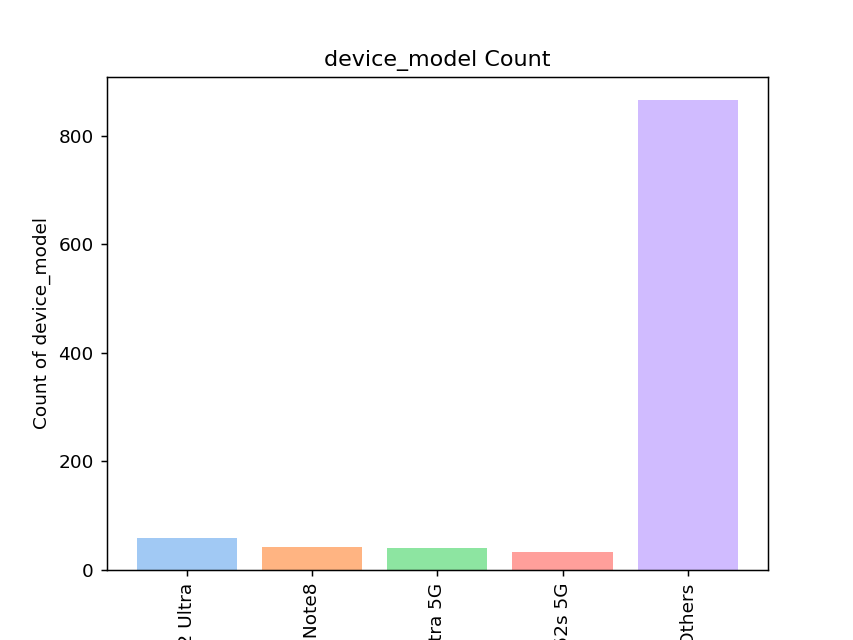

<IPython.core.display.Javascript object>


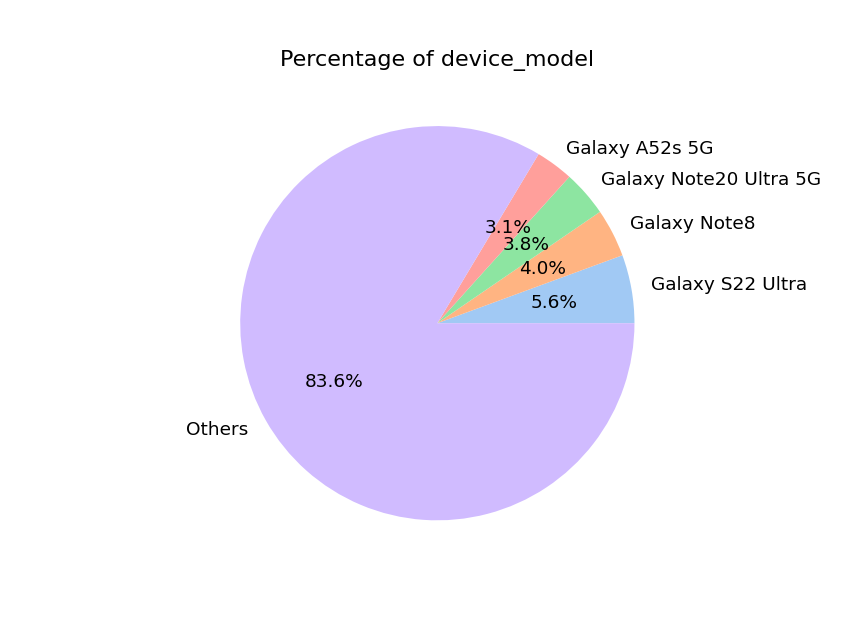

In [47]:
make_pie_chart_df('device_model',raw_bg_mobily_distinct_5g)

In [46]:
len(raw_bg_mobily_distinct_4g)

974

In [50]:
def feature_analysis(feature,dd):
    feat=dd[feature].value_counts().compute()
    if(len(feat.keys()))>5:    
        names=list(feat.keys())[:4]+(['Others'])
        plot_values=list(feat.values)[:4]+ [sum(list(feat.values)[5:])]
    else:
        names=list(feat.keys())
        plot_values=list(feat.values)        
    colors = sns.color_palette('pastel')
    plt.bar(names, plot_values, color=colors[:5])
    for i in range(len(names)):
        plt.text(i,plot_values[i],plot_values[i])
    plt.xlabel(feature)
    y_pos = range(len(names))
    plt.xticks(y_pos, names, rotation=90)
    plt.ylabel(f"Count of {feature}")
    plt.title(f"{feature} Count")
    plt.show()
    
    plt.pie(plot_values, autopct='%1.1f%%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}")
    plt.show()

In [51]:
def make_pie_chart_df(feature,df):
    feat=df[feature].value_counts()
    if(len(feat.keys()))>5:    
        names=list(feat.keys())[:4]+(['Others'])
        plot_values=list(feat.values)[:4]+ [sum(list(feat.values)[5:])]
    else:
        names=list(feat.keys())
        plot_values=list(feat.values)        
    colors = sns.color_palette('pastel')
    plt.bar(names, plot_values, color=colors[:5])

 
    plt.xlabel(feature)
    y_pos = range(len(names))
    plt.xticks(y_pos, names, rotation=90)
    plt.ylabel(f"Count of {feature}")
    plt.title(f"{feature} Count")
    plt.show()
    
    plt.pie(plot_values, autopct='%1.1f%%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}")
    plt.show()

In [52]:
def get_lists_pie_chart(feature,dd):
    feat=dd[feature].value_counts().compute()
    if(len(feat.keys()))>5:    
        names=list(feat.keys())[:4]+(['Others'])
        plot_values=list(feat.values)[:4]+ [sum(list(feat.values)[5:])]
    else:
        names=list(feat.keys())
        plot_values=list(feat.values)  
    return names,plot_values

In [53]:
def feature_analysis_per_tech(feature):
    colors = sns.color_palette('pastel')
    names,plot_values=get_lists_pie_chart(feature,raw_bg_mobily)
    plt.subplot(3,2,1)
    plt.pie(plot_values, autopct='%1.1f%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}:: Overall ")
    names,plot_values=get_lists_pie_chart(feature,raw_bg_mobily_2g)
    plt.subplot(3,2,3)
    plt.pie(plot_values, autopct='%1.1f%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}:: 2G ")
    names,plot_values=get_lists_pie_chart(feature,raw_bg_mobily_3g)
    plt.subplot(3,2,4)
    plt.pie(plot_values, autopct='%1.1f%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}:: 3G ")
    names,plot_values=get_lists_pie_chart(feature,raw_bg_mobily_4g)
    plt.subplot(3,2,5)
    plt.pie(plot_values, autopct='%1.1f%%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}:: 4G ")
    plt.subplot(3,2,6)
    plt.pie(plot_values, autopct='%1.1f%%',labels = names,colors=colors)
    plt.title(f"Percentage of {feature}:: 5G ")
    plt.show()
    
    

In [54]:
feature_analysis_per_tech('device_manufacturer')

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


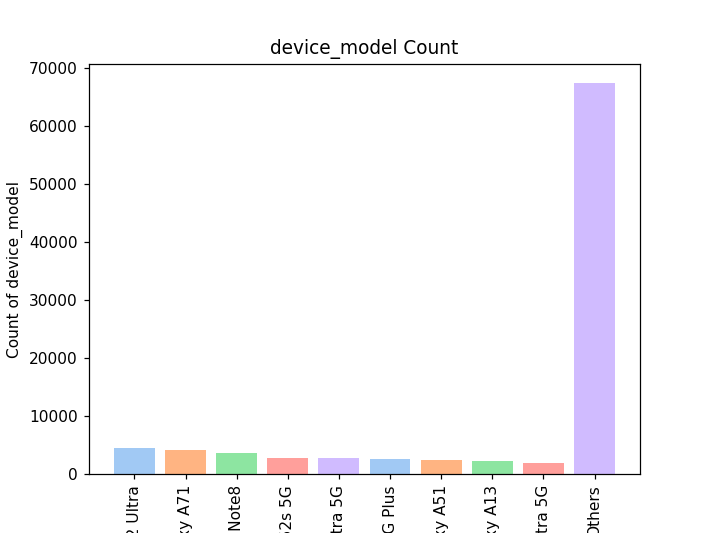

<IPython.core.display.Javascript object>


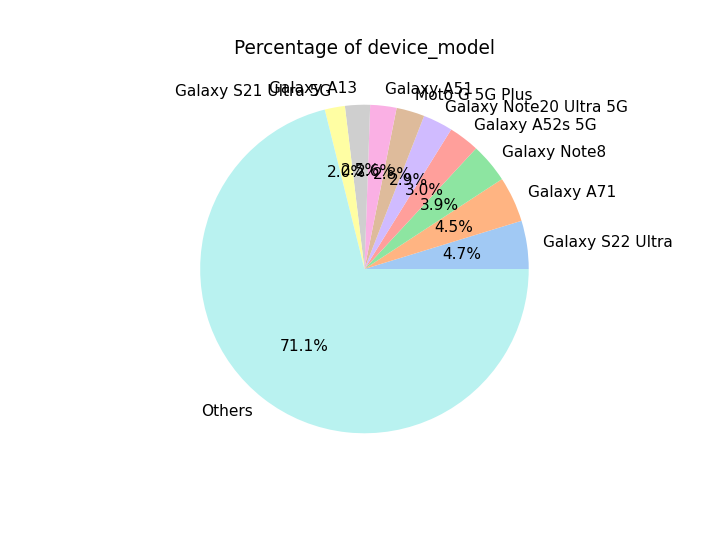

In [11]:
feature_analysis('device_model',raw_bg_mobily)

<IPython.core.display.Javascript object>


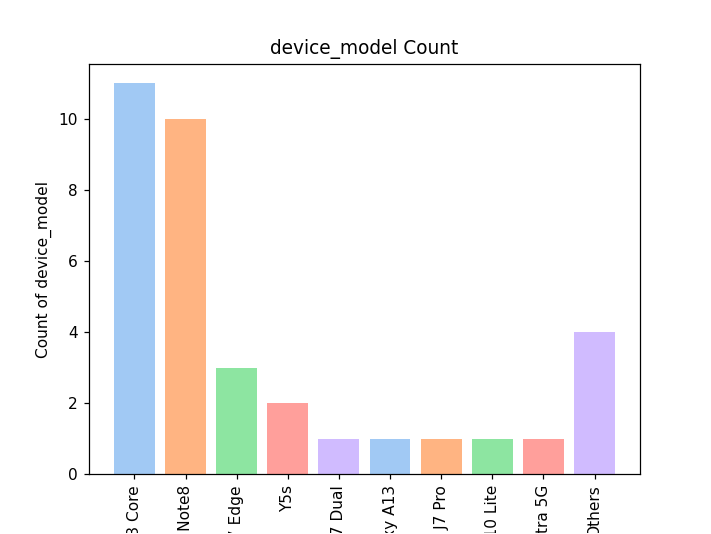

<IPython.core.display.Javascript object>


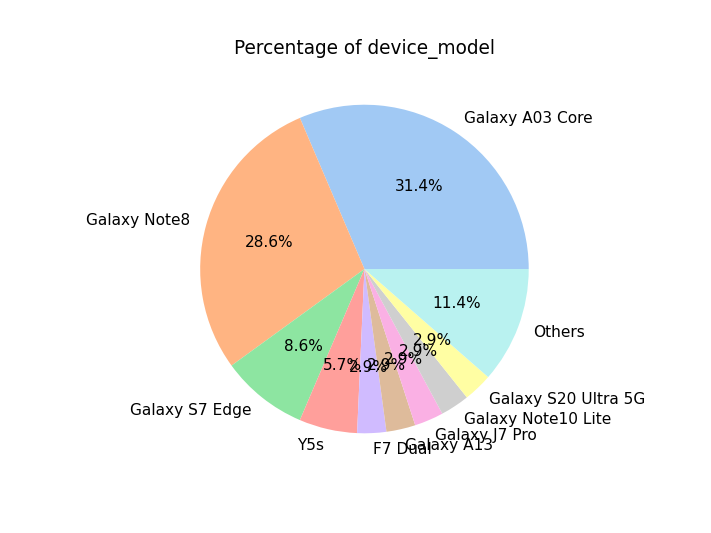

In [16]:
feature_analysis('device_model',raw_bg_mobily_2g)

<IPython.core.display.Javascript object>


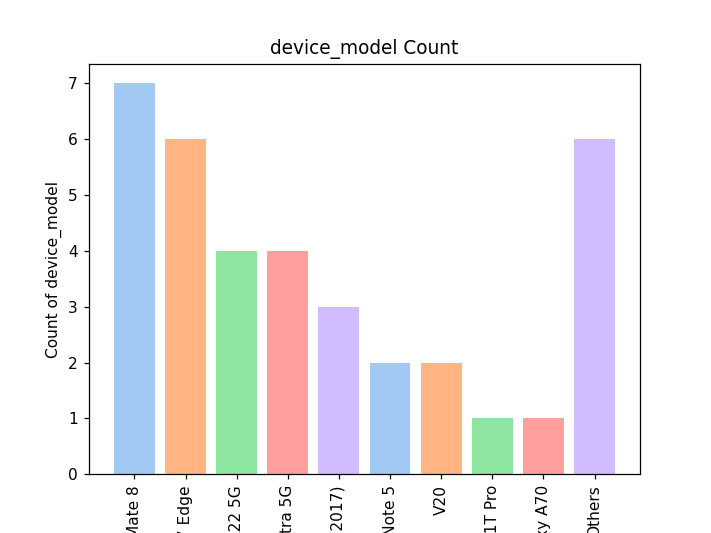

<IPython.core.display.Javascript object>


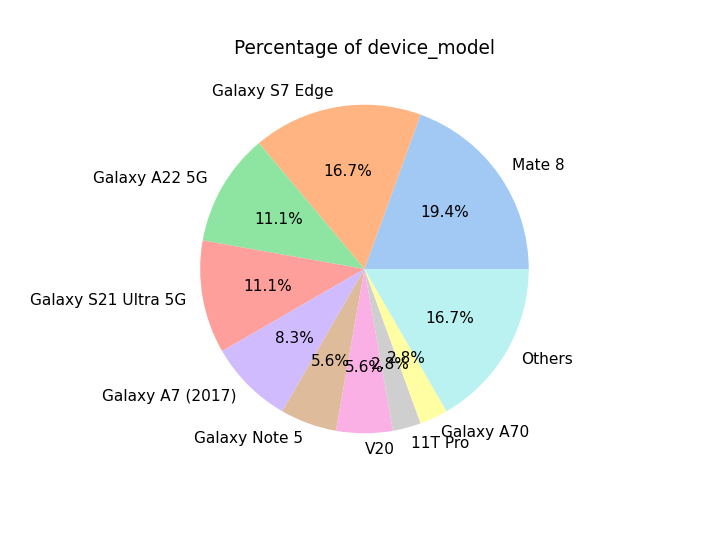

In [13]:
feature_analysis('device_model',raw_bg_mobily_3g)

<IPython.core.display.Javascript object>


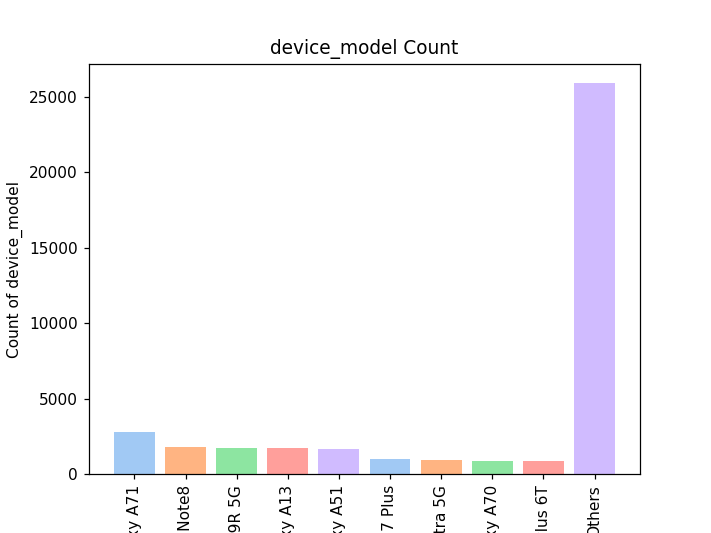

<IPython.core.display.Javascript object>


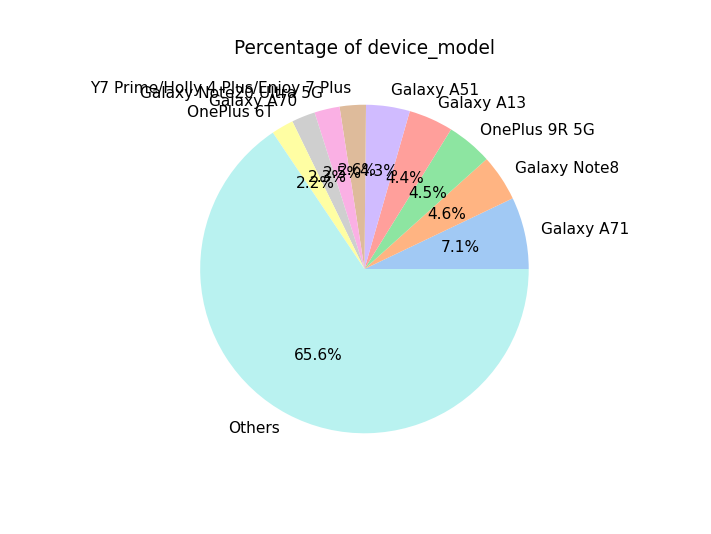

In [14]:
feature_analysis('device_model',raw_bg_mobily_4g)

<IPython.core.display.Javascript object>


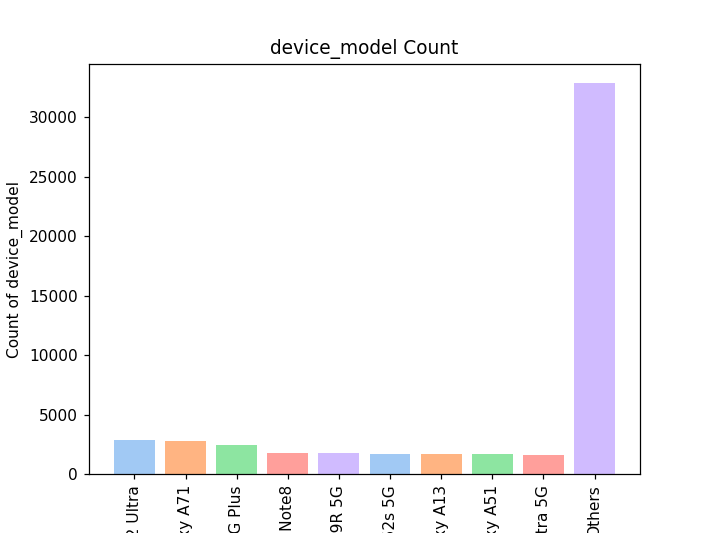

<IPython.core.display.Javascript object>


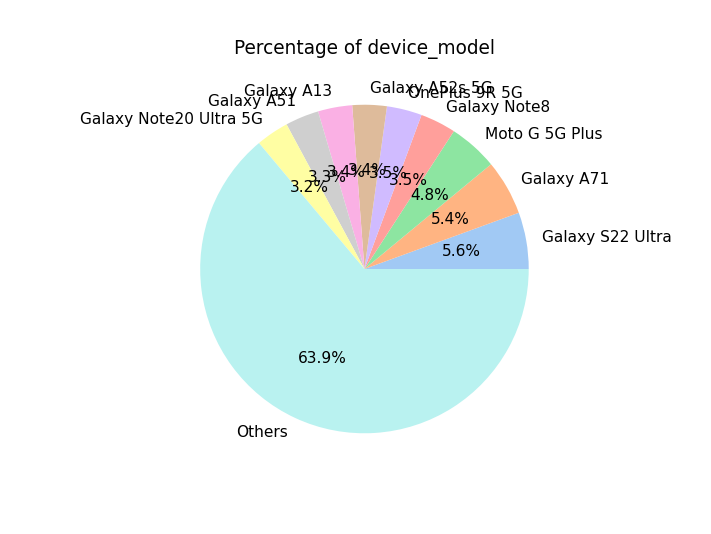

In [15]:
feature_analysis('device_model',raw_bg_mobily_5g)

# Roaming
is_network_roaming

<IPython.core.display.Javascript object>


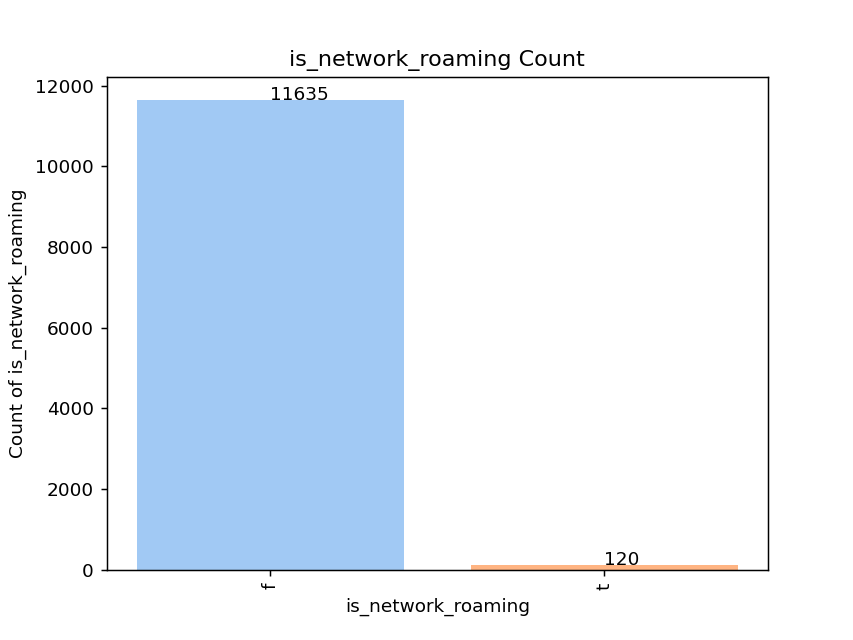

<IPython.core.display.Javascript object>


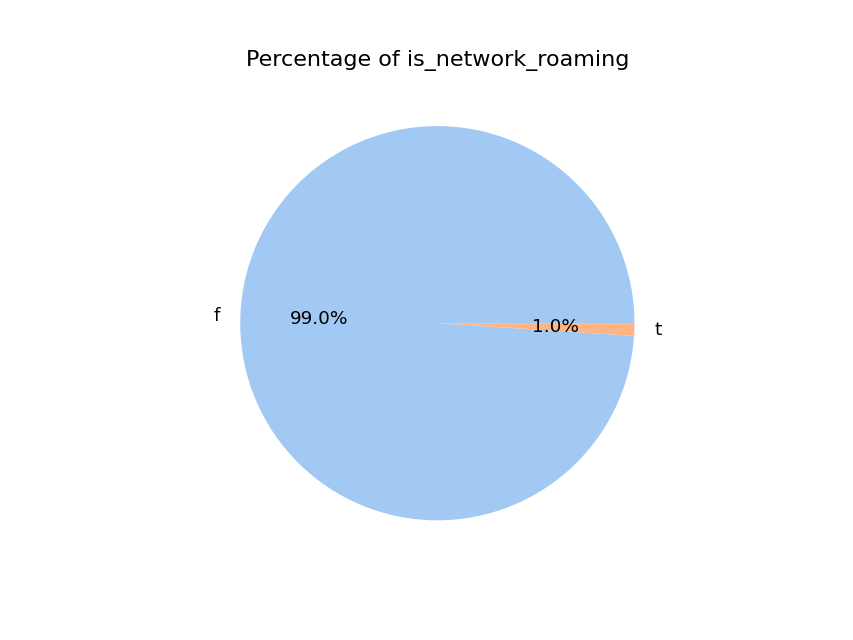

In [60]:
feature_analysis('is_network_roaming',raw_bg_mobily_5g)

# 5G Supported Devices Camped on 4G

Step-1 Get devices on 5G
Step-2 Filter 4G area where devices is in above range

In [13]:
devices_5g=raw_bg_mobily_5g['device_model'].unique().compute()

In [14]:
devices_5g=pd.DataFrame(devices_5g)

In [15]:
supp_5g_nw_4g=raw_bg_mobily_4g.merge(devices_5g,on='device_model').compute()

In [76]:
supp_5g_nw_4g.to_csv("supports_5g_camped_on_4g.csv")

In [77]:
len(raw_bg_mobily_5g)

12327

In [16]:
len(supp_5g_nw_4g)

9354

In [79]:
12327/(9354+12327)

0.5685623356856233

In [19]:
raw_bg_mobily['power_save_mode'].unique().compute()

In [27]:
supp_5g_nw_4g['bat_less_20']=supp_5g_nw_4g['battery_level'].apply(lambda x:x<20)

In [31]:
supp_5g_nw_4g[['bat_less_20','power_save_mode']].value_counts()

bat_less_20  power_save_mode
False        f                  7805
             t                  1201
True         f                   325
             t                    23
dtype: int64

# InterOperator Benchmark

In [33]:
raw_bg_stc=raw_bg_stc.query('locality in (\'Riyadh\')')
raw_bg_zain=raw_bg_zain.query('locality in (\'Riyadh\')')
raw_bg_stc_4g=raw_bg_stc.query('connection_type in (15,21)')
raw_bg_zain_4g=raw_bg_zain.query('connection_type in (15,21)')

In [35]:
info_4g_stc=raw_bg_stc_4g[['device_id','result_date','client_latitude','client_longitude','lte_enodeb','cell_id','earfcn','rsrp','rsrq','cqi']].compute()
info_4g_first_per_ci_stc=info_4g_stc.groupby(by=['device_id','lte_enodeb','cell_id'],as_index=False)['result_date'].min()
info_4g_corr_rsrp_stc=info_4g_first_per_ci_stc.merge(info_4g_stc,left_on=['device_id','lte_enodeb','cell_id','result_date'],
                            right_on=['device_id','lte_enodeb','cell_id','result_date'])


info_4g_zain=raw_bg_zain_4g[['device_id','result_date','client_latitude','client_longitude','lte_enodeb','cell_id','earfcn','rsrp','rsrq','cqi']].compute()
info_4g_first_per_ci_zain=info_4g_zain.groupby(by=['device_id','lte_enodeb','cell_id'],as_index=False)['result_date'].min()
info_4g_corr_rsrp_zain=info_4g_first_per_ci_zain.merge(info_4g_zain,left_on=['device_id','lte_enodeb','cell_id','result_date'],
                            right_on=['device_id','lte_enodeb','cell_id','result_date'])

In [36]:
info_4g_corr_rsrp_stc.to_csv('stc_riyadh.csv')
info_4g_corr_rsrp_zain.to_csv('zain_riyadh.csv')

In [40]:
pd.DataFrame(info_4g_corr_rsrp_zain['rsrp'].value_counts()).to_csv('zain_bins.csv')